In [2]:
import argparse
import ast
import gc
import h5py
import nd2
import os

import numpy as np
import matplotlib.pyplot as plt

%load_ext line_profiler

In [9]:
import psutil

def memory_usage():
    """Check the memory usage of the current Jupyter Notebook process."""
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    memory_in_mb = mem_info.rss / (1024 * 1024)  # Convert bytes to MB
    print(f"Current memory usage: {memory_in_mb:.2f} MB")

In [3]:
def load_h5(path, channels_to_load=None):
    with h5py.File(path, "r") as hdf5_file:
        data = hdf5_file["dataset"]

        # Select channels if channels_to_load is provided
        if channels_to_load is not None:
            data = data[:, :, channels_to_load].squeeze()
        else:
            data = data[:,:,:]

    return data

In [4]:
def get_shape_h5file(path, format=".h5"):
    """
    Get the width and height of a h5.
    """

    with h5py.File(path, "r") as f:
        shape = f["dataset"].shape
        f.close()

    return shape

In [5]:
import argparse
import gc
import h5py
import nd2
import os
import pickle

import numpy as np

import cv2

from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric


def _parse_args():
    """Parse command-line arguments."""
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "-c",
        "--crop_image",
        type=str,
        default=None,
        required=True,
        help="pickle containing fixed and moving crops, in this order.",
    )

    args = parser.parse_args()
    return args


def apply_mapping(mapping, x, method="dipy"):
    """
    Apply mapping to the image.

    Parameters:
        mapping: A mapping object from either the DIPY or the OpenCV package.
        x (ndarray): 2-dimensional numpy array to transform.
        method (str, optional): Method used for mapping. Either 'cv2' or 'dipy'. Default is 'dipy'.

    Returns:
        mapped (ndarray): Transformed image as a 2D numpy array.
    """
    # Validate the method parameter
    if method not in ["cv2", "dipy"]:
        raise ValueError("Invalid method specified. Choose either 'cv2' or 'dipy'.")

    # Apply the mapping based on the selected method
    if method == "dipy":
        mapped = mapping.transform(x)
    elif method == "cv2":
        height, width = x.shape[:2]
        mapped = cv2.warpAffine(x, mapping, (width, height))

    return mapped


def load_pickle(path):
    # Open the file in binary read mode
    with open(path, "rb") as file:
        # Deserialize the object from the file
        loaded_data = pickle.load(file)

    return loaded_data


def save_pickle(object, path):
    # Open a file in binary write mode
    with open(path, "wb") as file:
        # Serialize the object and write it to the file
        pickle.dump(object, file)



def apply_mapping(mapping, x, method="dipy"):
    """
    Apply mapping to the image.

    Parameters:
        mapping: A mapping object from either the DIPY or the OpenCV package.
        x (ndarray): 2-dimensional numpy array to transform.
        method (str, optional): Method used for mapping. Either 'cv2' or 'dipy'. Default is 'dipy'.

    Returns:
        mapped (ndarray): Transformed image as a 2D numpy array.
    """
    # Validate the method parameter
    if method not in ["cv2", "dipy"]:
        raise ValueError("Invalid method specified. Choose either 'cv2' or 'dipy'.")

    # Apply the mapping based on the selected method
    if method == "dipy":
        mapped = mapping.transform(x)
    elif method == "cv2":
        height, width = x.shape[:2]
        mapped = cv2.warpAffine(x, mapping, (width, height))

    return mapped


def load_pickle(path):
    # Open the file in binary read mode
    with open(path, "rb") as file:
        # Deserialize the object from the file
        loaded_data = pickle.load(file)

    return loaded_data


def save_pickle(object, path):
    # Open a file in binary write mode
    with open(path, "wb") as file:
        # Serialize the object and write it to the file
        pickle.dump(object, file)


def compute_diffeomorphic_mapping_dipy(
    y: np.ndarray, x: np.ndarray, sigma_diff=5, radius=4
):
    """
    Compute diffeomorphic mapping using DIPY.

    Parameters:
        y (ndarray): Reference image.
        x (ndarray): Moving image to be registered.
        sigma_diff (int, optional): Standard deviation for the CCMetric. Default is 20.
        radius (int, optional): Radius for the CCMetric. Default is 20.

    Returns:
        mapping: A mapping object containing the transformation information.
    """
    # Check if both images have the same shape
    if y.shape != x.shape:
        raise ValueError(
            "Reference image (y) and moving image (x) must have the same shape."
        )

    # Define the metric and create the Symmetric Diffeomorphic Registration object
    metric = CCMetric(2, sigma_diff=sigma_diff, radius=radius)
    sdr = SymmetricDiffeomorphicRegistration(metric, opt_tol=1e-03, inv_tol=0.1)

    # Perform the diffeomorphic registration using the pre-alignment from affine registration
    mapping = sdr.optimize(y, x)

    return mapping


In [6]:
import glob
path = '/hpcnfs/scratch/P_DIMA_ATTEND/imaging/attend_image_analysis/work/c7/8cd9fe2ccd7cd8f20a6c09a5382443'
files = glob.glob(f"{path}/*pkl")


In [7]:
fixed, moving = load_pickle(files[0])

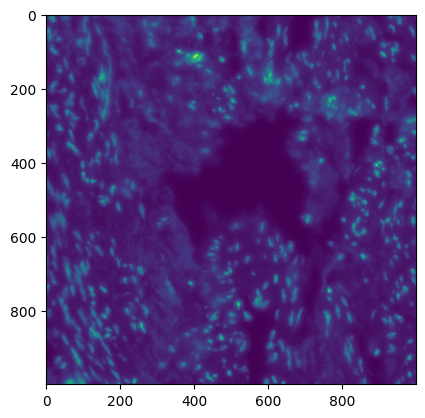

In [16]:
plt.imshow(fixed[8000:9000,8000:9000,2])

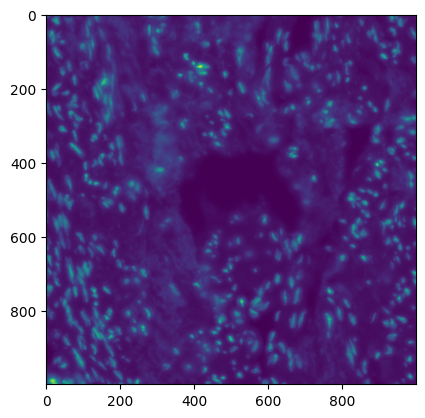

In [17]:
plt.imshow(moving[8000:9000,8000:9000,2])

In [10]:
memory_usage()

Current memory usage: 1353.79 MB


In [13]:
%lprun -f compute_diffeomorphic_mapping_dipy compute_diffeomorphic_mapping_dipy(y=fixed[:, :, 2].squeeze(), x=moving[:, :, 2].squeeze())

*** KeyboardInterrupt exception caught in code being profiled.

Timer unit: 1e-09 s

Total time: 20.8336 s
File: /tmp/ipykernel_31309/3765610447.py
Function: compute_diffeomorphic_mapping_dipy at line 117

Line #      Hits         Time  Per Hit   % Time  Line Contents
   117                                           def compute_diffeomorphic_mapping_dipy(
   118                                               y: np.ndarray, x: np.ndarray, sigma_diff=5, radius=4
   119                                           ):
   120                                               """
   121                                               Compute diffeomorphic mapping using DIPY.
   122                                           
   123                                               Parameters:
   124                                                   y (ndarray): Reference image.
   125                                                   x (ndarray): Moving image to be registered.
   126                                                   sigma_diff (int, optional): Standard

In [4]:
img_file = '/hpcnfs/scratch/P_DIMA_ATTEND/imaging/nd2conversion/work/f7/56f96e80940746c3e2f17582a09f35/19S30_DAPI_ARID1A_PDL1.h5'
get_shape_h5file(img_file)

(54992, 61429, 3)

In [5]:


img = load_h5(img_file)

In [9]:
memory_usage()

Current memory usage: 19434.98 MB


In [6]:
import numpy as np

def create_crops(image, crop_size, overlap_size):
    """
    Create overlapping crops from a 3D image.
    
    Args:
        image (numpy.ndarray): The input image of shape (X, Y, Z) with dtype uint16.
        crop_size (int): The size of the crops along X and Y (a x a).
        overlap_size (int): The overlap size along X and Y.
    
    Returns:
        list: A list of crops of shape (a, a, Z).
        list: A list of the top-left corner indices of each crop.
    """
    X, Y, Z = image.shape
    crops = []
    positions = []
    
    for x in range(0, X - overlap_size, crop_size - overlap_size):
        for y in range(0, Y - overlap_size, crop_size - overlap_size):
            # Ensure crop dimensions don't exceed the image dimensions
            x_end = min(x + crop_size, X)
            y_end = min(y + crop_size, Y)
            crop = image[x:x_end, y:y_end, :]
            crops.append(crop)
            positions.append((x, y))

    return crops, positions


def reconstruct_image(crops, positions, original_shape, crop_size, overlap_size):
    """
    Reconstruct the original image from overlapping crops.
    
    Args:
        crops (list): List of crops.
        positions (list): List of top-left corner indices for each crop.
        original_shape (tuple): Shape of the original image (X, Y, Z).
        crop_size (int): The size of the crops along X and Y.
        overlap_size (int): The overlap size along X and Y.
    
    Returns:
        numpy.ndarray: The reconstructed image of dtype uint16.
    """
    X, Y, Z = original_shape
    reconstructed = np.zeros(original_shape, dtype=img.dtype)  # Use uint16 for intermediate sums
    

    for crop, (x, y) in zip(crops, positions):

        # Shape crops
        c_x, c_y, _ = crop.shape
        # border
        if y == 0:
            y_start = y
            y_end = y + crop.shape[1] - overlap_size // 2 
            crop = crop[:, :(crop.shape[1] - overlap_size // 2 ), :]
            
        elif y == Y - c_y: # border
            y_start = y + overlap_size // 2
            y_end = y + crop.shape[1]
            crop = crop[:, (overlap_size // 2):, :]
            
        else: # no border
            y_start = y + overlap_size // 2
            y_end = y + crop.shape[1] - overlap_size // 2 
            crop = crop[:, (overlap_size // 2):(crop.shape[1] - overlap_size // 2 ), :]

        # border
        if x == 0:
            x_start = x
            x_end = x + crop.shape[0] - overlap_size // 2 
            crop = crop[:(crop.shape[0] - overlap_size // 2 ), :, :]
        elif x == X - c_x: # border
            x_start = x + overlap_size // 2
            x_end = x + crop.shape[0]
            crop = crop[(overlap_size // 2):, :, :]
        else: # no border
            x_start = x + overlap_size // 2
            x_end = x + crop.shape[0] - overlap_size // 2 
            crop = crop[(overlap_size // 2):(crop.shape[0] - overlap_size // 2 ), :, :]
        reconstructed[x_start:x_end, y_start:y_end, :] += crop
        del crop
        gc.collect()
        memory_usage()
    # Convert back to uint16
    return reconstructed


In [15]:
img_crop = img[12000:23111,12000:23111,:]

In [16]:
img_crop.shape

(11111, 11111, 3)

In [17]:
%%time

crop_size = 1000
overlap_size = 300

crops, positions = create_crops(img_crop, crop_size, overlap_size)

memory_usage()
# Example usage
reconstructed_image = reconstruct_image(
    crops, positions, original_shape=img_crop.shape, crop_size=crop_size, overlap_size=overlap_size
)

# Check the reconstruction
print(f"Reconstructed image shape: {reconstructed_image.shape}")

Current memory usage: 20600.32 MB
Current memory usage: 20654.58 MB
Current memory usage: 20654.62 MB
Current memory usage: 20654.75 MB
Current memory usage: 20654.75 MB
Current memory usage: 20654.88 MB
Current memory usage: 20655.01 MB
Current memory usage: 20655.14 MB
Current memory usage: 20655.26 MB
Current memory usage: 20655.26 MB
Current memory usage: 20655.39 MB
Current memory usage: 20655.52 MB
Current memory usage: 20655.64 MB
Current memory usage: 20655.64 MB
Current memory usage: 20655.78 MB
Current memory usage: 20655.91 MB
Current memory usage: 20655.91 MB
Current memory usage: 20699.91 MB
Current memory usage: 20699.91 MB
Current memory usage: 20699.91 MB
Current memory usage: 20699.91 MB
Current memory usage: 20699.91 MB
Current memory usage: 20699.91 MB
Current memory usage: 20699.91 MB
Current memory usage: 20699.91 MB
Current memory usage: 20699.91 MB
Current memory usage: 20699.91 MB
Current memory usage: 20699.91 MB
Current memory usage: 20699.91 MB
Current memory

In [30]:
memory_usage()

Current memory usage: 38777.89 MB


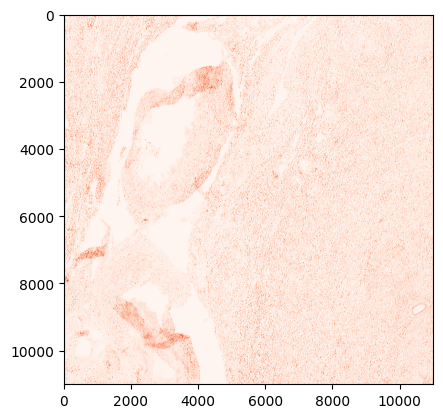

In [11]:
plt.imshow(img_crop[:,:,2], cmap="Reds")

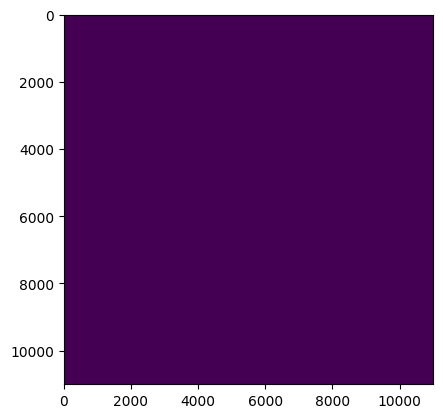

In [12]:
plt.imshow((reconstructed_image - img_crop)[:,:,0].squeeze())

In [18]:
(reconstructed_image[:,:,1] == img_crop[:,:,1]).all()

True

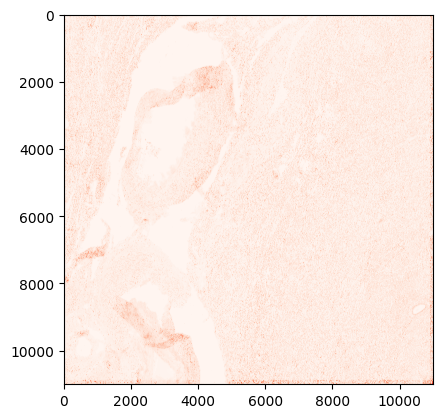

In [241]:
plt.imshow(reconstructed_image[:,:,2], cmap="Reds")

In [215]:
np.quantile(reconstructed_image, 0.2)

609.0

In [214]:
np.quantile(img_crop, 0.2)

609.0

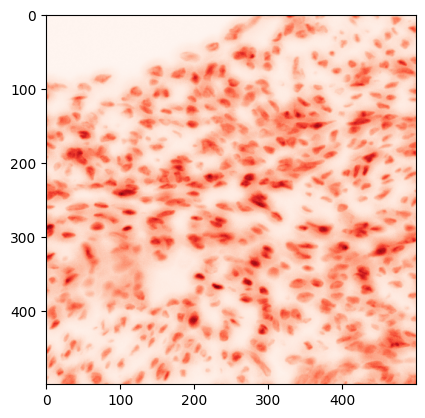

In [137]:
plt.imshow(crops[0][:,:,2], cmap="Reds")

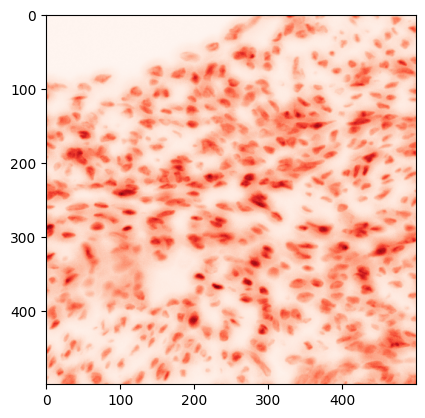

In [138]:
plt.imshow(img_crop[:500,:500,2], cmap="Reds")

In [158]:
reconstructed_image 

array([[[ 651,  621,  117],
        [ 563,  678,  112],
        [ 541,  714,  118],
        ...,
        [ 699,  883, 1404],
        [ 578,  913, 1430],
        [ 615,  867, 1130]],

       [[ 559,  614,  129],
        [ 549,  587,  108],
        [ 663,  752,  128],
        ...,
        [ 674,  908, 1292],
        [ 597,  861, 1187],
        [ 632,  787, 1164]],

       [[ 561,  737,  118],
        [ 571,  642,  113],
        [ 576,  640,  117],
        ...,
        [ 542,  962, 1172],
        [ 634,  844, 1119],
        [ 670,  898, 1106]],

       ...,

       [[ 565,  676,  131],
        [ 561,  596,  135],
        [ 595,  664,  134],
        ...,
        [ 592,  667,  164],
        [ 607,  664,  177],
        [ 633,  709,  165]],

       [[ 555,  570,  128],
        [ 648,  629,  147],
        [ 578,  735,  133],
        ...,
        [ 576,  673,  179],
        [ 492,  545,  201],
        [ 596,  651,  179]],

       [[ 564,  649,  125],
        [ 534,  669,  138],
        [ 545,  

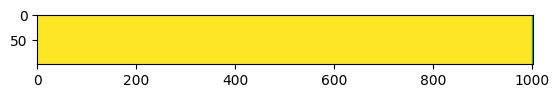

In [176]:
plt.imshow((reconstructed_image[100:200,3000:4002, 2] == img_crop[100:200,3000:4002,2]))

In [206]:
a = (reconstructed_image - img_crop)[:,:,2].squeeze()

In [208]:
np.unique(a)

array([    0,    96,    99, ..., 26436, 26739, 27006], dtype=uint16)

In [209]:
reconstructed_image[a == 96]

array([[1096, 1356,  192]], dtype=uint16)

In [210]:
img_crop[a == 96]

array([[548, 678,  96]], dtype=uint16)

In [170]:
x

np.sum(reconstructed_image[:2000,:1000, 1] - img_crop[:,:, 1])

107165200

In [268]:
assert img_crop.shape != img_crop.shape

AssertionError: 